> That is, when will we afford a house?

# Motivation

In [1]:
## TODO

# Introduction

In [2]:
## TODO

We will have following sections:

0. Zipcode and Shape Data
1. Income Data
2. House Price Data
3. Income v.s. House Price

# Setup

Run following command in your terminal:

    $ pip install -r requirements.txt

# Zipcode and Shape Data

## Retrieve Zip Code List

In [3]:
import os
import json
import ntpath
import wget

In [4]:
"""
Reference: https://catalog.data.gov/dataset/bay-area-zip-codes
"""
def get_bay_area_zipcode():
    
    url = "https://data.sfgov.org/api/views/f9wk-m4qb/rows.json?accessType=DOWNLOAD"
    filename = "rows.json"

    # Remove previous downloaded csv file if exists
    try:
        os.remove(ntpath.basename(filename))
    except OSError:
        pass
    
    filename = wget.download(url)
    with open(filename) as f:
        raw_data = json.load(f)
        zipcode_list = [row[10] for row in raw_data["data"]]
    return zipcode_list

In [49]:
zipcode_list = get_bay_area_zipcode()
print(len(zipcode_list))
print(zipcode_list)

187
['94558', '94533', '95620', '95476', '94559', '94954', '94571', '94535', '94503', '94949', '94945', '94512', '94591', '94510', '94592', '94589', '94947', '94590', '94946', '94561', '94525', '94569', '94585', '94103', '94565', '94903', '94520', '94572', '94553', '94547', '94963', '94938', '94502', '94509', '94960', '94513', '94109', '94521', '94930', '94973', '94933', '94598', '94564', '94801', '94519', '94806', '94901', '94531', '94803', '94601', '94523', '94518', '94904', '94115', '94549', '94517', '94805', '94804', '94939', '94964', '94530', '94925', '94596', '94708', '94105', '94941', '94563', '94720', '94707', '94514', '94970', '94706', '94710', '94104', '94595', '94709', '94703', '94704', '94507', '94702', '94965', '94556', '94920', '94118', '94705', '94611', '94618', '94609', '94550', '94608', '94528', '94526', '94506', '94130', '94607', '94123', '94610', '94583', '94602', '94612', '94546', '94133', '94129', '94606', '94111', '94619', '94121', '94102', '94552', '94501', '9410

## Retrieve Shape Data

In [6]:
import os
import zipfile
import shutil
import shapefile

In [7]:
"""
Source: https://www.census.gov/geo/maps-data/data/cbf/cbf_zcta.html
"""
def download_zipcode_shapefile():
    
    url = "http://www2.census.gov/geo/tiger/GENZ2016/shp/cb_2016_us_zcta510_500k.zip"
    output = "./data/"
    target = "./data/cb_2016_us_zcta510_500k.shp"
    
    # Remove previous extracted folder if exists
    try:
        shutil.rmtree(output)
    except OSError:
        pass
    
    # Remove previous downloaded zip file if exists
    try:
        os.remove(ntpath.basename(url))
    except OSError:
        pass
    
    # Download and extract
    zip_data = wget.download(url)
    with zipfile.ZipFile(zip_data) as zip_ref:
        zip_ref.extractall(output)
        
    return target

In [8]:
raw_data = download_zipcode_shapefile()
shape_records = shapefile.Reader(raw_data).shapeRecords()

In [9]:
def filter_shape_record(shape_records, zipcode_list):
    filtered = []
    for sr in shape_records:
        if sr.record[0] in zipcode_list:
            filtered.append(sr)
    return filtered

In [10]:
filtered_shape_records = filter_shape_record(shape_records, zipcode_list)
print(len(filtered_shape_records), len(zipcode_list))

186 187


# Income

## Retrieve Income Data

In [11]:
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

In [12]:
"""
Source: https://factfinder.census.gov/faces/nav/jsf/pages/community_facts.xhtml
Example: https://factfinder.census.gov/rest/communityFactsNav/nav?spotlightId=INCOME&searchTerm=94041
"""
def get_avg_income_by_zipcode(zipcode):
    url = "https://factfinder.census.gov/rest/communityFactsNav/nav?spotlightId=INCOME&searchTerm=" + str(zipcode)
    req = requests.get(url=url)
    html = req.json()["CFMetaData"]["measureAndLinksContent"]
    dom = BeautifulSoup(html, "lxml")
    try:
        income = re.sub('[^0-9]','', dom.findAll("div", {"class": "value"})[0].text)
    except Exception:
        print("No value found for zipcode %s" % zipcode)
        return None
    print(zipcode, income)
    return income

In [13]:
# Test
zipcode = 94558
avg_income = get_avg_income_by_zipcode(zipcode)

94558 77299


In [65]:
def get_income(zipcode_list):
    m = {}
    for zipcode in zipcode_list:
        income = get_avg_income_by_zipcode(zipcode)
        if income:
            m[zipcode] = int(income)
    income = pd.DataFrame.from_dict(m, orient = "index")
    income.columns = ["income"]
    income.sort_values(by=["income"], inplace=True, ascending=False)
    return income

In [66]:
income = get_income(zipcode_list)

94558 77299
94533 57316
95620 72583
95476 68894
94559 65891
94954 83713
94571 54852
94535 54692
94503 83627
94949 78568
94945 90685
No value found for zipcode 94512
94591 73897
94510 87569
94592 110648
94589 57316
94947 88119
94590 41530
94946 108750
94561 81910
94525 78750
94569 136875
94585 70491
94103 46140
94565 60020
94903 92552
94520 51096
94572 70227
94553 84638
94547 102993
94963 91806
94938 103854
94502 115765
94509 55022
94960 112045
94513 93951
94109 71043
94521 88339
94930 99338
94973 90824
94933 76393
94598 125089
94564 73861
94801 43393
94519 74351
94806 52698
94901 82231
94531 90126
94803 78759
94601 41918
94523 94042
94518 78301
94904 111845
94115 97090
94549 147368
94517 128398
94805 72009
94804 51276
94939 99844
94964 107167
94530 91052
94925 125915
94596 82869
94708 147837
94105 195165
94941 131703
94563 174526
No value found for zipcode 94720
94707 140711
94514 54348
94970 109412
94706 86043
94710 63080
94104 51500
94595 62374
94709 63701
94703 68842
94704 26173
945

In [67]:
# zipcodes with top high income
income.head()

,income
94027,243542
94028,229554
94024,204534
94105,195165
94022,194014


## Plot

In [68]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as cmx

In [71]:
def get_normalized_df(df):
    return (df - df.min()) / (df.max() - df.min())

In [72]:
normalized_df = get_normalized_df(income)
print(normalized_df.get_value("94558", "income"))

0.23520373190289323


In [84]:
"""
Reference: https://gis.stackexchange.com/questions/131716/plot-shapefile-with-matplotlib
"""
def plot_shapes(shape_records, record2value, column_name):
    plt.clf()
    plt.figure()
    for sr in shape_records:
        index = sr.record[0]
        try:
            val = record2value.get_value(index, column_name)
        except KeyError:
            continue
        x = [i[0] for i in sr.shape.points[:]]
        y = [i[1] for i in sr.shape.points[:]]
        plt.fill(x, y, get_heapmap_color_hex(val))
    plt.show()
    plt.close()

In [85]:
"""
Jet colormap: https://www.mathworks.com/help/matlab/ref/jet.html
"""
def get_heapmap_color_hex(val):
    r, g, b = plt.cm.jet(val)[:3]
    return "#%02x%02x%02x" % (int(r * 255), int(g * 255), int(b * 255))

In [86]:
print(get_heapmap_color_hex(0.5))
print(get_heapmap_color_hex(1.0))

#7cff79
#7f0000


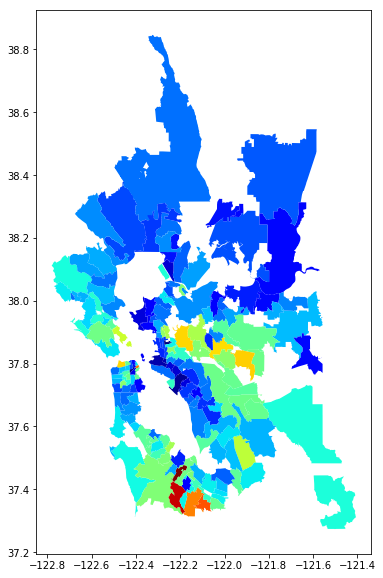

In [87]:
plt.rcParams["figure.figsize"] = [6, 10] # Size: [width, height]
plot_shapes(filtered_shape_records, normalized_df, "income")

# House Price Data

## Retrieve House Price Data

The house price data is downloaded from [Zillow](https://www.zillow.com/research/data/), that has the house price from 1996 to 2018. For this project, we will use the most recent house price.

In [88]:
def load_data(file_name):
    
    df = pd.read_csv(file_name, na_filter=False)
        
    # drop instance with missing values
    df = df.replace("", pd.np.nan).dropna(how='any')
    
    # convert values to int data type
    y = "1996"
    m = "04"
    date = y + "-" + m
    while date != "2018-02":        
        df[date] = df[date].apply(pd.to_numeric)       
        if m == "12":
            m = "01"
            y = str(int(y)+1)
        else:
            m = int(m)+1
            if m < 10:
                m = "0"+str(m)
            else:
                m = str(m)       
        date = y + "-" + m
    
    # convert zipcode to string data type
    df['RegionName'] = df['RegionName'].apply(str)
    
    # set zipcode as index
    df.set_index('RegionName', inplace=True)
    return df

houses = load_data("homes_CA.csv")

In [89]:
houses.head()

,RegionID,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,...,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02
RegionName,,,,,,,,,,,,,,,,,,,,,
93306,97222,Bakersfield,CA,Bakersfield,Kern,333,86800,87100,87500,88200,...,186300,186300,186500,187000,187700,188500,189400,190600,192100,193700
93307,97223,Bakersfield,CA,Bakersfield,Kern,343,67000,66800,67100,67800,...,159100,159600,159400,159200,159900,160300,160800,161500,162600,164000
93309,97225,Bakersfield,CA,Bakersfield,Kern,348,89000,89200,89100,88700,...,188300,189300,189700,190300,191200,191900,192000,192200,193200,194500
93308,97224,Oildale,CA,Bakersfield,Kern,587,82700,83500,84000,84700,...,190000,190500,191000,191100,191000,191100,191700,191800,192600,194100
93312,97227,Bakersfield,CA,Bakersfield,Kern,747,132400,132300,132300,131900,...,272500,272700,272500,272900,273800,274700,275600,276600,277900,279600


## Get the Most Recent House Price

In [90]:
def get_most_recent_houseprice(df):
    house_price = df[["2018-02"]].copy()
    house_price.rename(columns={"2018-02": "price"}, inplace=True)
    return house_price

most_recent_houseprice = get_most_recent_houseprice(houses)   

In [91]:
most_recent_houseprice.head()

,price
RegionName,
93306,193700
93307,164000
93309,194500
93308,194100
93312,279600


In [92]:
# zipcodes with top low house price

most_recent_houseprice.sort_values(by=['price'], inplace=True)
most_recent_houseprice.head()

,price
RegionName,
93501,101100
92365,117200
92277,123700
93241,124600
93268,127000


## Retrieve Shape Data

We reuse the shapa data from the first section.

## Plot

In [93]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm as cmx

In [94]:
normalized_df = get_normalized_df(most_recent_houseprice)
print(normalized_df.get_value("94558", "price"))

0.0987472787686667


In [96]:
plt.rcParams["figure.figsize"] = [6, 10] # Size: [width, height]

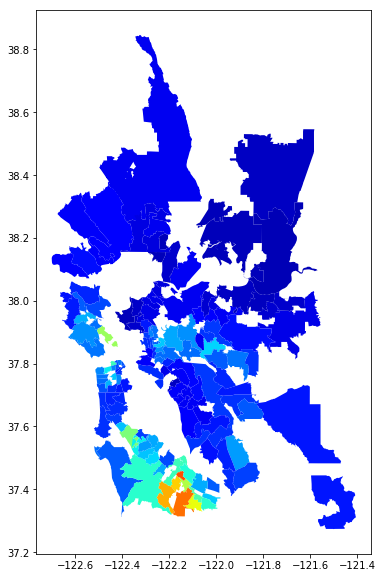

In [97]:
plot_shapes(filtered_shape_records, normalized_df, "price")

# Income v.s. House Price

In [59]:
# Merge house price and income table
income_vs_houseprice = pd.merge(zipcode2income_df, most_recent_houseprice,
                                how="inner",left_index=True, right_index=True)
income_vs_houseprice["years_needed"] = income_vs_houseprice["price"] / income_vs_houseprice["income"]
income_vs_houseprice = income_vs_houseprice.sort_values("years_needed")
income_vs_houseprice.head()

,income,price,years_needed
94531,90126,479100,5.315891
94585,70491,383700,5.443248
94561,81910,455300,5.558540
94105,195165,1125900,5.768965
95620,72583,423400,5.833322


In [61]:
print(income_vs_houseprice.loc["94040"]["price"], income_vs_houseprice.loc["94040"]["income"])

2414300.0 115600.0


## Living in the same zipcode

In [101]:
normalized_df = get_normalized_df(income_vs_houseprice)
normalized_df.head()

,income,price,years_needed
94531,0.314449,0.030418,0.000000
94585,0.217906,0.007016,0.001979
94561,0.274052,0.024579,0.003770
94105,0.830913,0.189079,0.007040
95620,0.228192,0.016754,0.008040


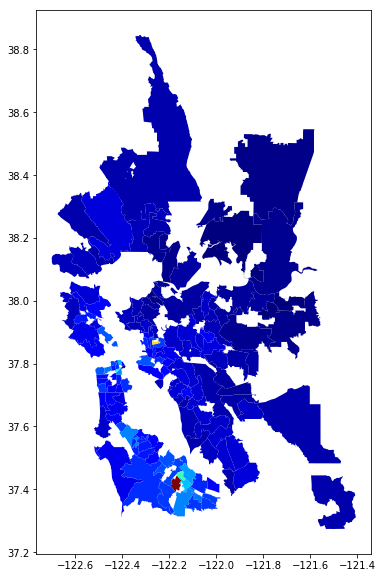

In [102]:
plot_shapes(filtered_shape_records, normalized_df, "years_needed")

## Living close to where you work

In [129]:
import geopy.distance
from statistics import median

In [127]:
def get_shape_center(shape):
    lats = [point[0] for point in shape.points]
    lngs = [point[1] for point in shape.points]
    return median(lats), median(lngs)

In [128]:
print(get_shape_center(filtered_shape_records[0].shape))

(-121.603149, 37.37496)


In [143]:
THRESHOLD_MILES = 10 # Maximum miles you want to commute every workday
def get_neighbor_list(shape_records):
    
    # Builds zipcode -> center map
    zipcode_center = {}
    for rs in shape_records:
        zipcode = rs.record[0]
        zipcode_center[zipcode] = get_shape_center(rs.shape)
    
    # Builds neighbor list
    neighbor_list = {}
    for rs in shape_records:
        zipcode = rs.record[0]
        center = zipcode_center[zipcode]
        neighbor_list[zipcode] = [
            neighbor for neighbor in zipcode_center.keys()
            if geopy.distance.vincenty(zipcode_center[neighbor], center).miles <= THRESHOLD_MILES
        ]
    
    return neighbor_list

In [144]:
neighbor = get_neighbor_list(filtered_shape_records)
neighbor["94040"]

['94085',
 '94089',
 '94027',
 '94305',
 '94560',
 '94086',
 '94028',
 '94544',
 '94306',
 '94024',
 '94022',
 '94025',
 '94538',
 '94043',
 '94301',
 '94545',
 '94303',
 '94040',
 '94555',
 '94087',
 '95002',
 '94304',
 '94587']